## Import Libraries

In [1]:
import pandas as pd
import numpy as np

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("white")
sns.despine()
%matplotlib inline

In [3]:
# Correlation
from scipy.stats import pointbiserialr

In [4]:
# Train - Test Split
from sklearn.model_selection import train_test_split
# Pre-processing
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MinMaxScaler
# Cross - Validate
from sklearn.model_selection import cross_val_score, RandomizedSearchCV
# Metrics
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
# Models:
from sklearn.linear_model import SGDRegressor, Lasso, LassoLars, LinearRegression, Ridge

# Ensemble
from sklearn.ensemble import RandomForestRegressor

## Load Data

In [5]:
df = pd.read_csv('house.csv')
# Check what the data look like
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987


In [6]:
# Checking data types, and if there is null values
# No null values for all columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 15 columns):
id               21613 non-null int64
date             21613 non-null object
price            21613 non-null float64
bedrooms         21613 non-null int64
bathrooms        21613 non-null float64
sqft_living      21613 non-null int64
sqft_lot         21613 non-null int64
floors           21613 non-null float64
waterfront       21613 non-null int64
view             21613 non-null int64
condition        21613 non-null int64
grade            21613 non-null int64
sqft_above       21613 non-null int64
sqft_basement    21613 non-null int64
yr_built         21613 non-null int64
dtypes: float64(3), int64(11), object(1)
memory usage: 2.5+ MB


### Exploratory Data Analysis

In [7]:
# Checking if id column is unique; id column is not unique
df['id'].is_unique

False

In [7]:
# Checking duplicate rows
df[df.duplicated(['id'], keep=False)]
# rows that has duplicates are units that were sold more than once

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built
93,6021501535,20140725T000000,430000.0,3,1.50,1580,5000,1.0,0,0,3,8,1290,290,1939
94,6021501535,20141223T000000,700000.0,3,1.50,1580,5000,1.0,0,0,3,8,1290,290,1939
313,4139480200,20140618T000000,1380000.0,4,3.25,4290,12103,1.0,0,3,3,11,2690,1600,1997
314,4139480200,20141209T000000,1400000.0,4,3.25,4290,12103,1.0,0,3,3,11,2690,1600,1997
324,7520000520,20140905T000000,232000.0,2,1.00,1240,12092,1.0,0,0,3,6,960,280,1922
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20670,8564860270,20150330T000000,502000.0,4,2.50,2680,5539,2.0,0,0,3,8,2680,0,2013
20779,6300000226,20140626T000000,240000.0,4,1.00,1200,2171,1.5,0,0,3,7,1200,0,1933
20780,6300000226,20150504T000000,380000.0,4,1.00,1200,2171,1.5,0,0,3,7,1200,0,1933
21580,7853420110,20141003T000000,594866.0,3,3.00,2780,6000,2.0,0,0,3,9,2780,0,2013


In [9]:
# Adding a feature: 'sold more than once'
df2 = pd.DataFrame(df.pivot_table(index=['id'], aggfunc='size'))
df2.columns = ['freq_sold']

df2['sold_morethan_once'] = df2['freq_sold'].apply(lambda x: 0 if (x == 1) else 1)
# Create a column for id
df2.reset_index(inplace=True)

In [10]:
# Merge sold_morethan_once feature
df = pd.merge(df, df2[['id', 'sold_morethan_once']], on='id')
df.head()
del df2

In [11]:
# Change the datatype of date column from string to datetime
df['date'] = pd.to_datetime(df['date'])
# Extract year from date column
df['yr_sold'] = df['date'].dt.year

In [12]:
# Adding a feature: 'age_when_sold' ; yr_build - yr_sold
df['age_when_sold'] = df['yr_sold'] - df['yr_built']

In [13]:
print("Date range is from ", df['date'].min(), " to ", df['date'].max())
# Drop date, since the data is from 02 May 2014 to 27 May 2015. Correlation that will be made between price and date will not be as reliable

Date range is from  2014-05-02 00:00:00  to  2015-05-27 00:00:00


In [14]:
# Drop unnecessary columns
drop_col = ['id', 'date', 'yr_sold', 'yr_built']
df.drop(drop_col, axis=1, inplace=True)

#### Visualization

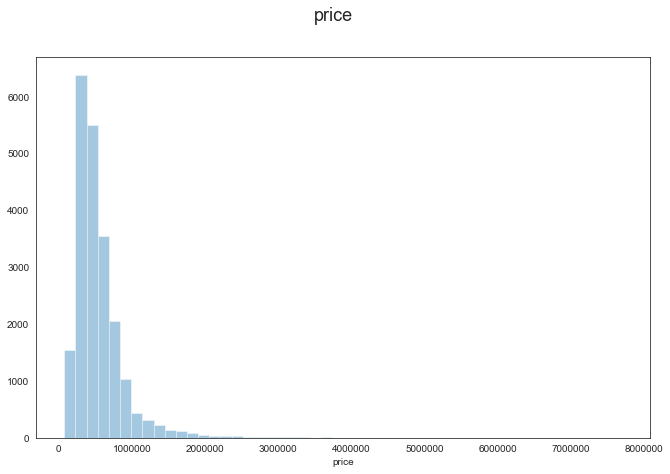

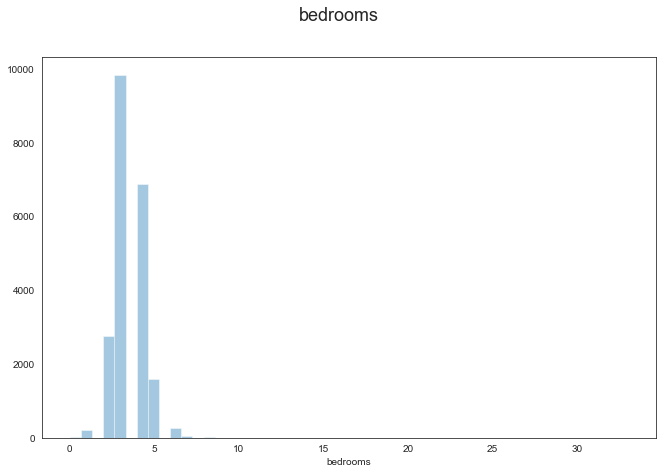

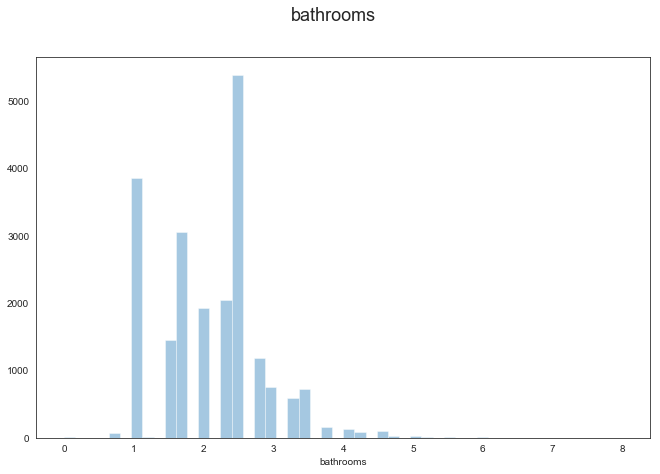

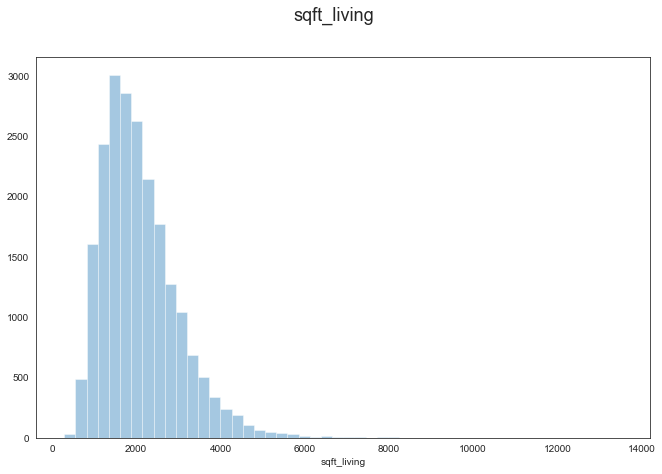

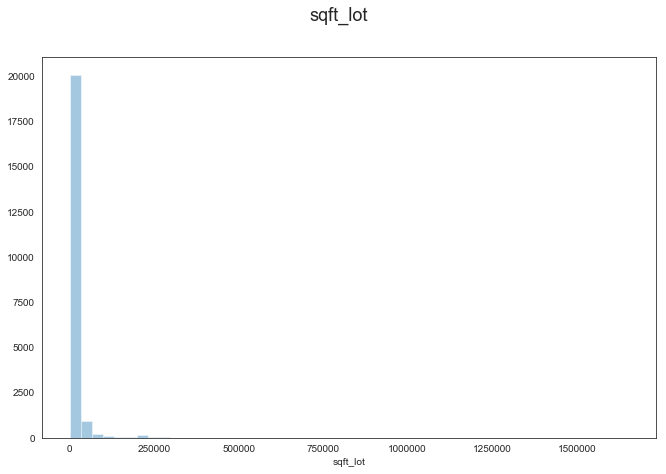

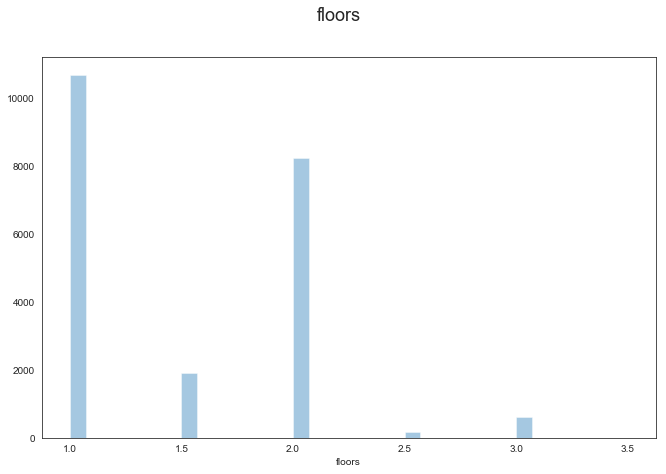

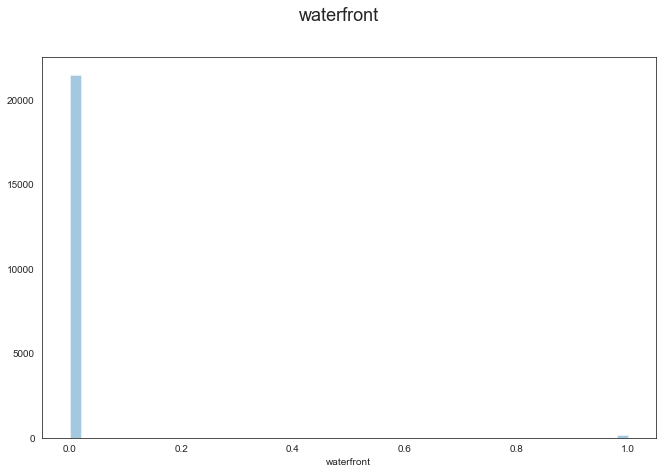

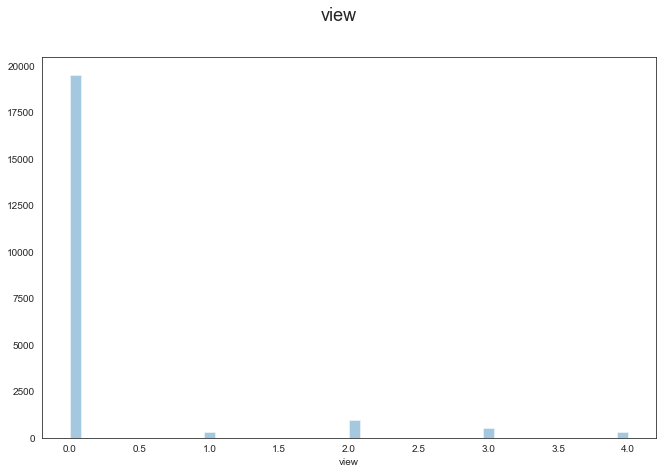

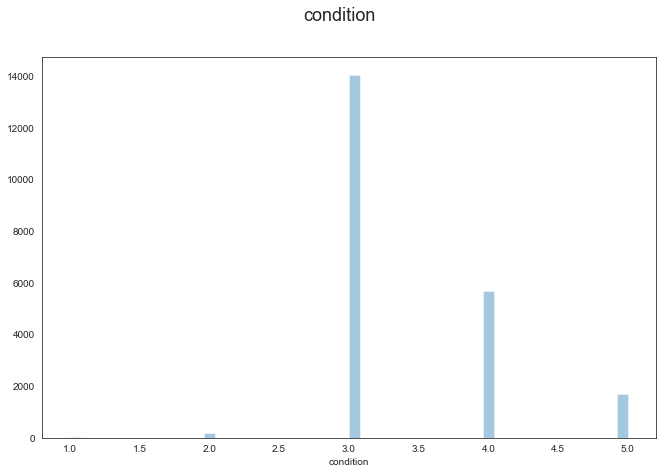

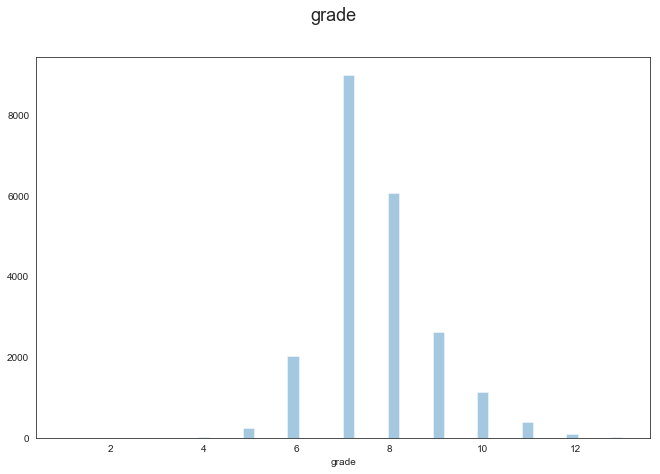

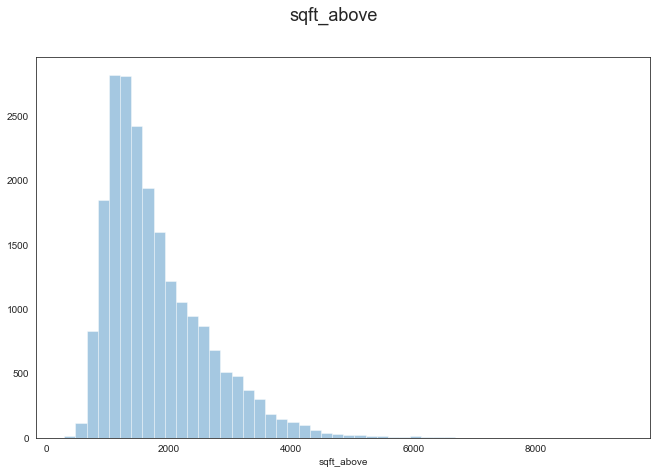

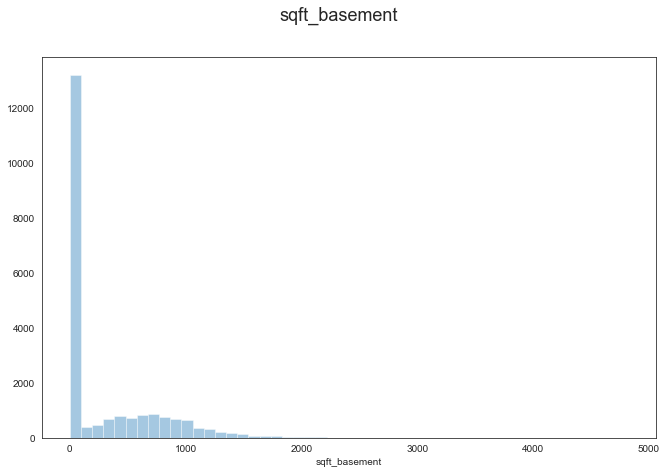

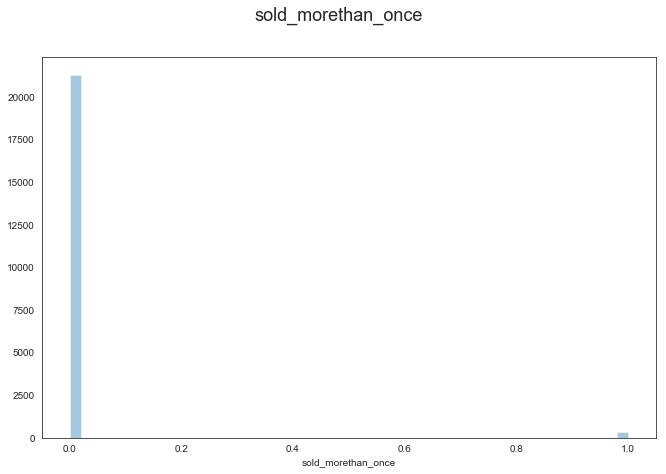

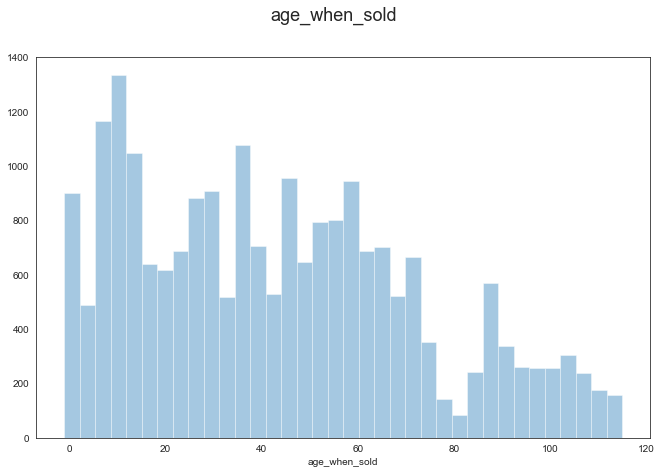

In [15]:
hist_plt = ['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 
            'waterfront', 'view', 'condition', 'grade', 'sqft_above', 
            'sqft_basement', 'sold_morethan_once', 'age_when_sold']

for i in hist_plt:
    f, ax = plt.subplots(figsize=(11, 7))
    sns.distplot(a=df[i], hist=True, kde=False, rug=False)
    title = i
    f.suptitle(title, fontsize=18)

Observations:

- The distribution of price appears to be skewed to the right. Average price of houses are at around $500,000, but there are also few houses that are priced more than 10x the average price.
- number of bedrooms, number of bathrooms, sqft_lot, number of floors, sqft_above, sqft_basement are also skewed to the right
- condition, grade are skewed to the left
- age_when_sold is dispersed
- majority of the houses sold are sold the first time
- majority of the houses do not have waterfront

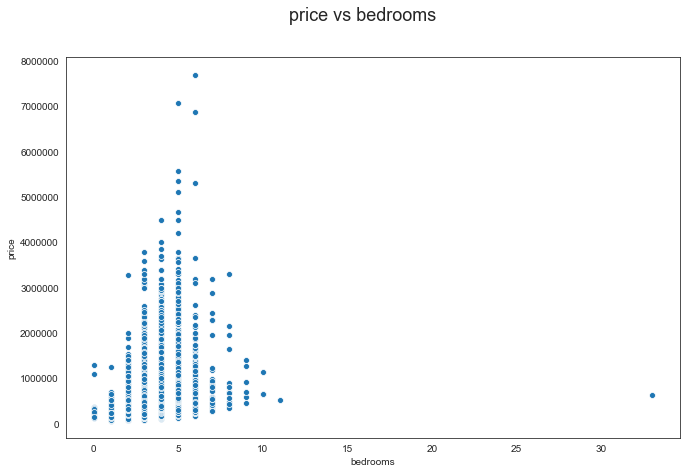

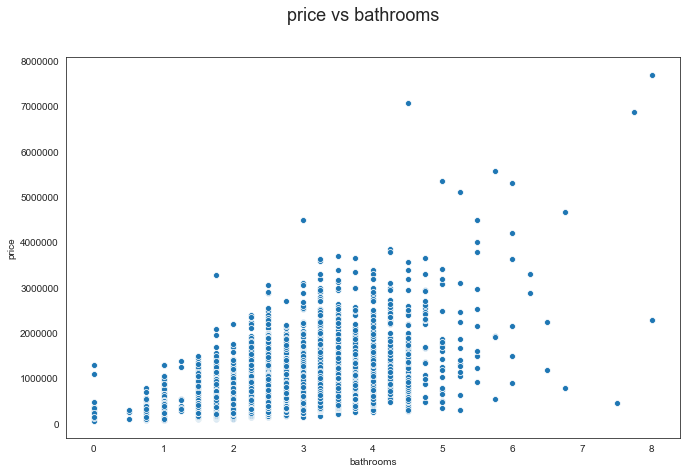

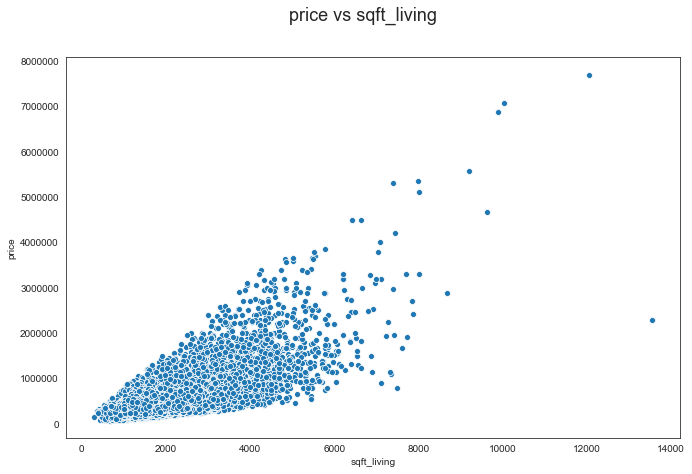

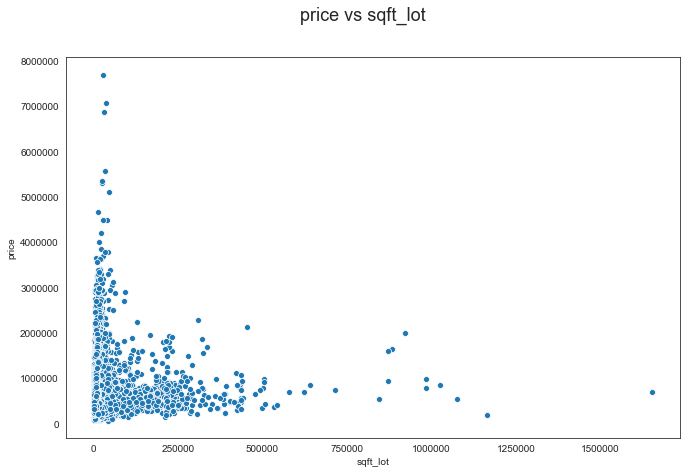

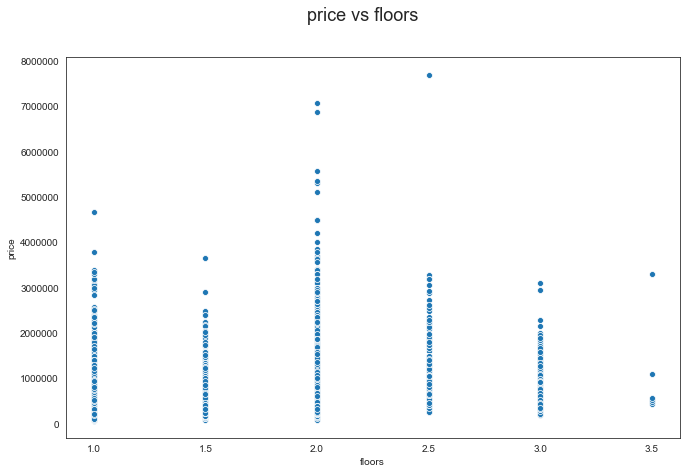

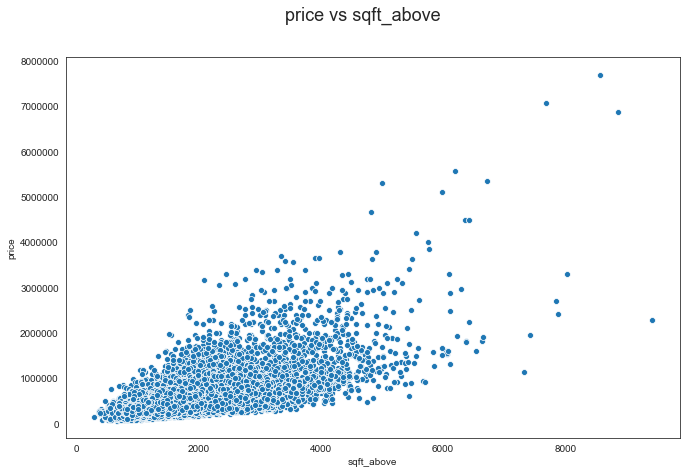

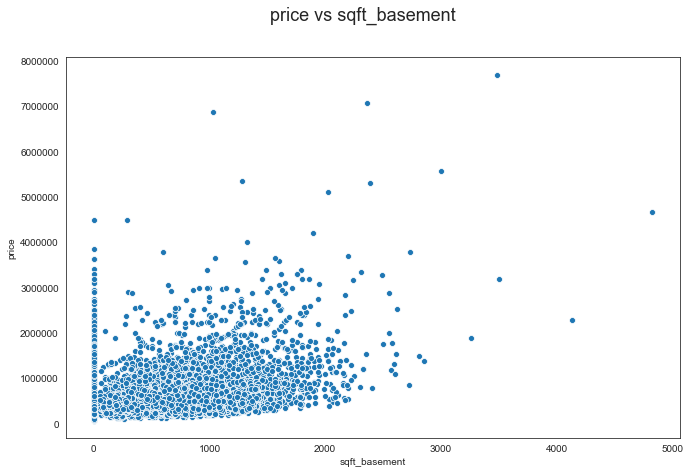

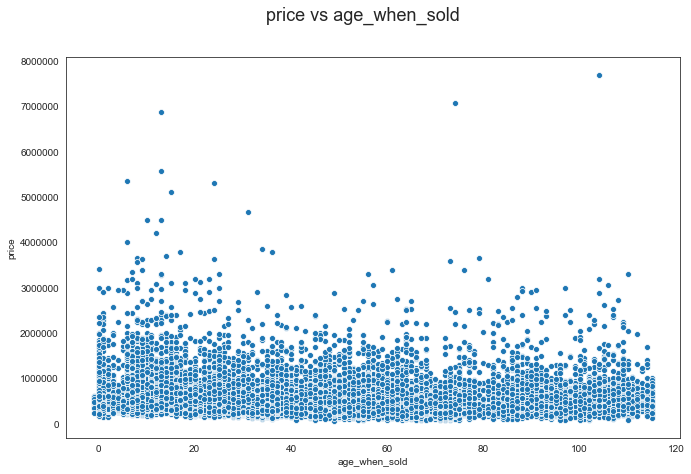

In [16]:
scat_plt = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 
            'floors', 'sqft_above', 'sqft_basement', 'age_when_sold']
for i in scat_plt:
    f, ax = plt.subplots(figsize=(11, 7))
    sns.scatterplot(x=i, y="price", data=df)
    title = 'price vs ' + i  
    f.suptitle(title, fontsize=18)
    
    
# Based on the charts below, 

Observations:

- sqft_living, sqft_above, sqft_basement are correlated with price. As seen on the scatter plot above, when sqft_living / sqft_above / sqft_basement / number of bathroom is high, it is almost always that the price is also high.
- personally, i assume that the higher the number of bedroom, the higher the price. However in the scatter plot, it is not the case. The price is highest when the number of bedroom is around 5. (it makes sense because who needs a house that has a lot of bedroom) 
- another interesting point: the age does not really correlate with the price. The house age does not really affect the price of the house.

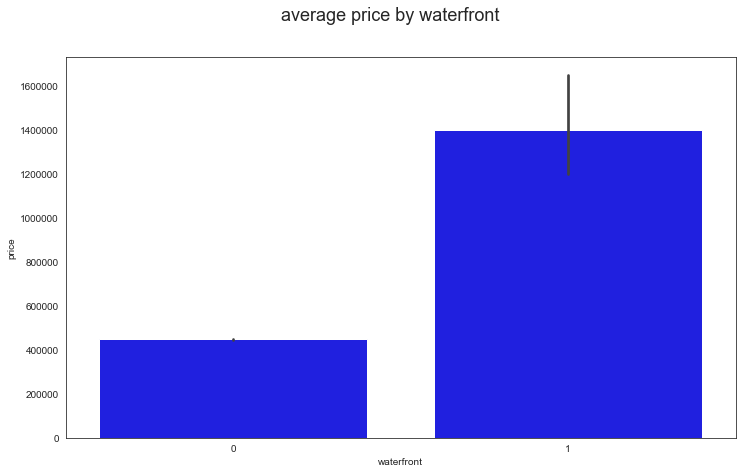

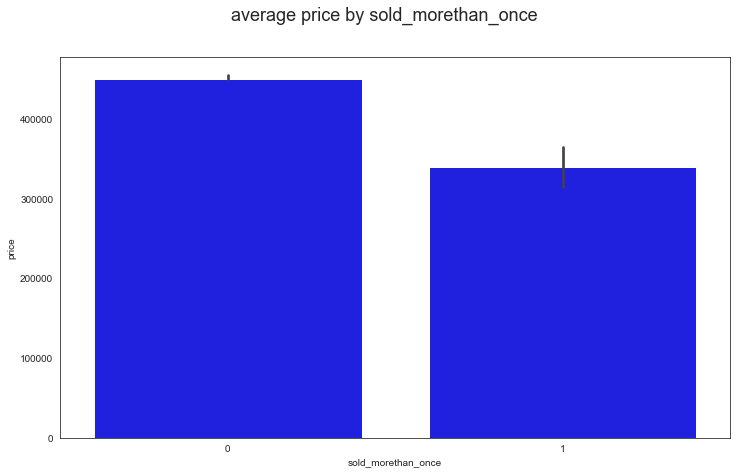

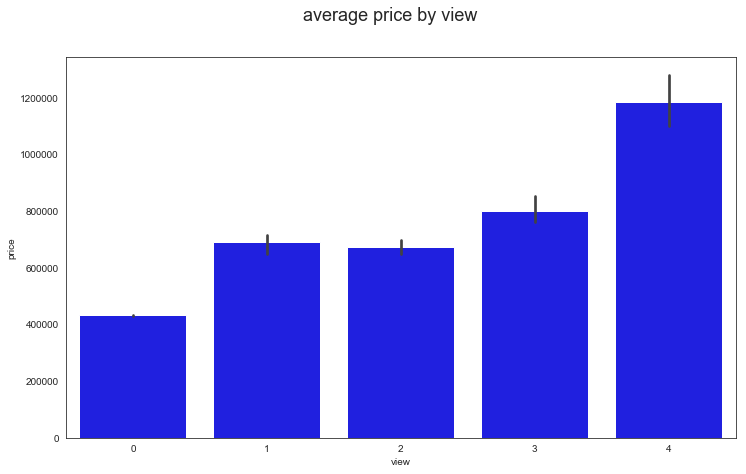

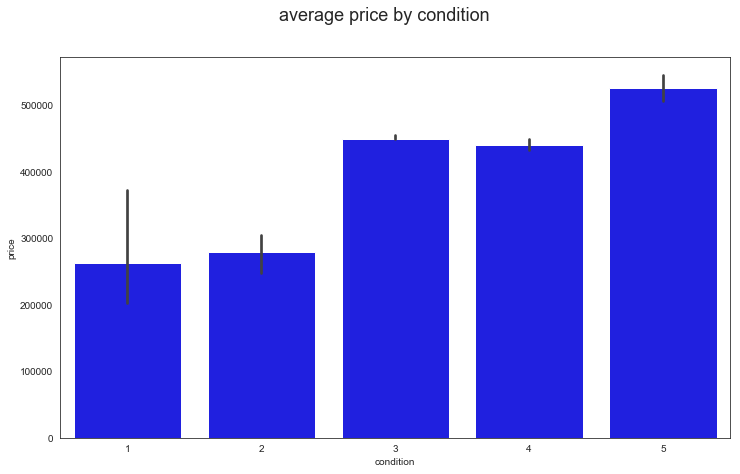

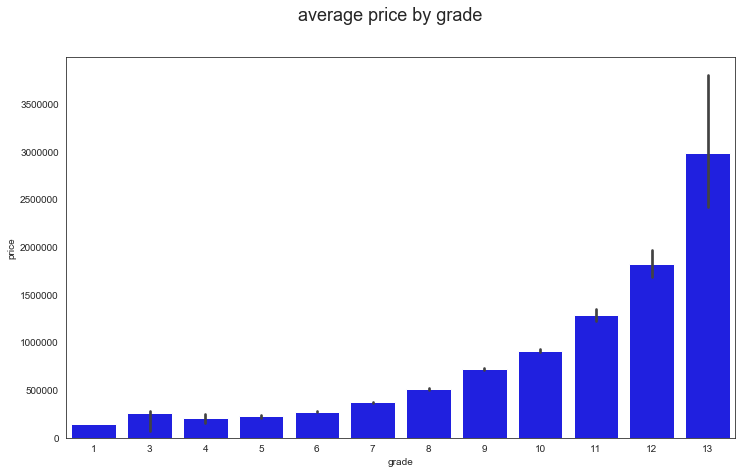

In [17]:
bar_plt = ['waterfront', 'sold_morethan_once', 'view', 'condition', 'grade']

for i in bar_plt:
    f, ax = plt.subplots(figsize=(12, 7))
    sns.barplot(x=i, y="price", data=df, estimator = np.median, color='blue')
    title = 'average price by ' + i
    f.suptitle(title, fontsize=18)

# Based on the chart below, 

Observations:
- Average price of a house with waterfront is higher compared to a house without waterfront. However, since the number of observations between house with waterfront and without waterfront is heavily imbalanced, it is not final to assume that house with waterfront costs higher.
- Houses that are sold the first time has higher price compared to houses that are sold more than once. Does the value of a house decreases when it gets sold more than once? With more data, this can be a valuable feature
- For view, condition, and grade, the higher the rating the higher the average price

#### Correlation Mattrix

In [18]:
# binary features:
bin_feat = ['waterfront', 'sold_morethan_once']
# ordinal features:
ord_feat = ['view', 'condition', 'grade']
# continous features:
cont_feat = ['price','bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 
             'floors', 'sqft_above', 'sqft_basement', 'age_when_sold']
# list of all columns
col_list = ['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 
            'waterfront', 'view', 'condition', 'grade', 'sqft_above', 
            'sqft_basement', 'sold_morethan_once', 'age_when_sold']

In [19]:
# Preparation for the correlation table
# List all combination of x, y
list_combination = [(x,y) for x in col_list for y in col_list]

In [20]:
# Creating lists for correlation table

corr_list = []
x = 0
for row in range(0, 196, 14):
    x += 1
    corr_row = []
    for col in range(x):

        rows = list_combination[row][0]
        cols = list_combination[col][1]
        
        if (rows in cont_feat) and (cols in cont_feat):
            # Pearson's R
            corr = df[rows].corr(df[cols])
            corr_row.append(corr)
            
        elif ((rows in cont_feat) and (cols in bin_feat)) or ((cols in cont_feat) and (rows in bin_feat)):
            # Point-biserial
            corr = pointbiserialr(df[rows], df[cols])[0]
            corr_row.append(corr)
            
        elif ((rows in cont_feat) and (cols in ord_feat)) or ((cols in cont_feat) and (rows in ord_feat)):
            # Spearman's Rho
            corr = df[rows].corr(df[cols], method='spearman')
            corr_row.append(corr)
        
        elif (rows in ord_feat) and (cols in ord_feat):
            # Kendall's Tau
            corr = df[rows].corr(df[cols], method='kendall')
            corr_row.append(corr)
        
        elif ((rows in ord_feat) and (cols in bin_feat)) or ((cols in ord_feat) and (rows in bin_feat)):
            # Kendall's Tau
            corr = df[rows].corr(df[cols])
            corr_row.append(corr)
            
        elif (rows in bin_feat) and (cols in bin_feat):
            # Spearman's Rho
            corr = df[rows].corr(df[cols])
            corr_row.append(corr)
        else:
            corr = 0
            corr_row.append(corr)
        
    corr_list.append(corr_row)


In [21]:
# Append zero
x = 14
for i in range(len(corr_list)):
    x -= 1
    for y in range(x):
        corr_list[i].append(0)

corr = pd.DataFrame(corr_list, columns=col_list, index=col_list)
corr

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,sold_morethan_once,age_when_sold
price,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
bedrooms,0.308350,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
bathrooms,0.525138,0.515884,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
sqft_living,0.702035,0.576671,0.754665,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
sqft_lot,0.089661,0.031703,0.087740,0.172826,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
floors,0.256794,0.175429,0.500653,0.353949,-0.005201,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
waterfront,0.266369,-0.006582,0.063744,0.103818,0.021604,0.023698,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
view,0.293931,0.081421,0.155549,0.232994,0.117033,0.019655,0.401857,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
condition,0.018490,0.012660,-0.162891,-0.062638,0.114724,-0.287915,0.016653,0.043801,1.000000,0.000000,0.000000,0.000000,0.000000,0.0
grade,0.658215,0.380534,0.658194,0.716400,0.152049,0.501684,0.082775,0.195493,-0.148802,1.000000,0.000000,0.000000,0.000000,0.0


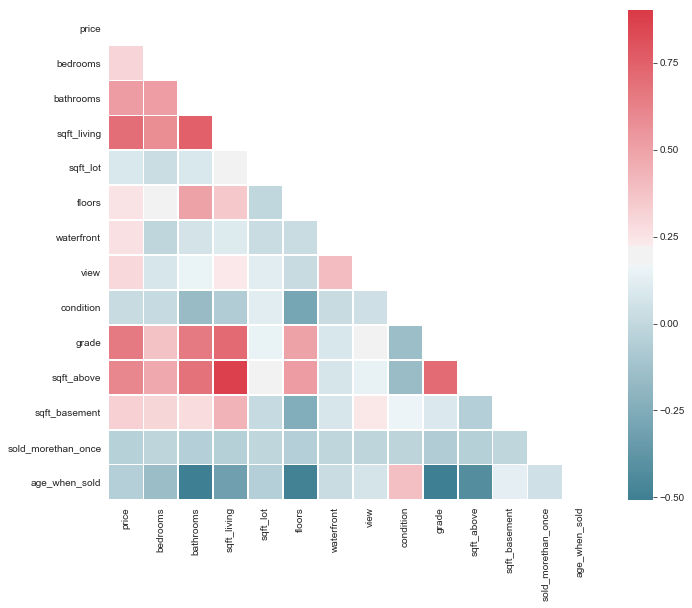

In [22]:
# Visualize Correlation

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.9, square=True, linewidths=.5, ax=ax, xticklabels=True, yticklabels=True)

Observations:
- As shown in the correlation table, features: sqft_living, sqft_above, bedrooms, bathrooms, grade, are highly correlated to each other. This indicate that there are redundant feature among the features mentioned above.
- sqft_living, grade, sqft_above, bathrooms, sqft_basement, and bedrooms are features that are highly correlated with price

### Feature Selection

In [23]:
# dropping sqft_above feature only. 
# not dropping sqft_living, bedrooms, bathrooms, and grade -- these columns may be highly correlated but they are not dependent to each other

drop_col = ['sqft_above']
df.drop(drop_col, axis=1, inplace=True)

In [24]:
# Get correlation churn VS features, sort ascending -- to determine which features to drop
corr_price = corr['price'].abs()
# Sort values, drop churn row
corr_price = pd.DataFrame(corr_price.sort_values().drop(['price']))

# Make index a column namely Features
corr_price = corr_price.reset_index()
corr_price = corr_price.rename(columns={'index': 'features'})
corr_price

# As shown in the table below, there are features that are not highly correlated with the target
# However, I will not remove those features yet.
# Check first how those features will interact with the models

,features,price
0,condition,0.018490
1,sold_morethan_once,0.042278
2,age_when_sold,0.053951
3,sqft_lot,0.089661
4,floors,0.256794
5,waterfront,0.266369
6,view,0.293931
7,bedrooms,0.308350
8,sqft_basement,0.323816
9,bathrooms,0.525138


## Modelling

#### Split Train-Test

In [25]:
# Set all columns datatype as float64
df = df.astype('float64')

# Separate X = features, Y = Target
X = df.drop(['price'], axis=1)
Y = df['price']

In [26]:
# Split data set to train-test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, random_state=12)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((15129, 12), (15129,), (6484, 12), (6484,))

In [27]:
# Scaling the data using StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
# apply same transformation to test data
X_test = scaler.transform(X_test)

In [28]:
# Create dictionary to store metrics
pred_dict = {}

#### Ordinary Least Squares (OLS)

In [29]:
# Instantiate Model, fit and predict
ols_model = LinearRegression()
ols_model.fit(X_train, y_train)
pred_ols = ols_model.predict(X_test)

In [30]:
# Metrics
r2 = r2_score(y_test, pred_ols)
mae = mean_absolute_error(y_test, pred_ols)
mse = mean_squared_error(y_test, pred_ols)

pred_dict['OLS'] = [format(r2, '.2f'), format(mae, '.2f'), format(mse, '.2f')]

print('Accuracy for OLS is ', r2)

Accuracy for OLS is  0.6426486894445744


#### Stochastic Gradient Descent (SGD)

In [31]:
# Instantiate Model, fit and predict
sgd_model = SGDRegressor()
sgd_model.fit(X_train, y_train)
pred_sgd = sgd_model.predict(X_test)

In [32]:
# Metrics
r2 = r2_score(y_test, pred_sgd)
mae = mean_absolute_error(y_test, pred_sgd)
mse = mean_squared_error(y_test, pred_sgd)

pred_dict['SGD'] = [format(r2, '.2f'), format(mae, '.2f'), format(mse, '.2f')]

print('Accuracy for SGD is ', r2)

Accuracy for SGD is  0.6393335129422


#### Ridge

In [33]:
# Instantiate Model, fit and predict
ridge_model = Ridge()
ridge_model.fit(X_train, y_train)
pred_ridge = ridge_model.predict(X_test)

In [34]:
# Metrics
r2 = r2_score(y_test, pred_ridge)
mae = mean_absolute_error(y_test, pred_ridge)
mse = mean_squared_error(y_test, pred_ridge)

pred_dict['Ridge'] = [format(r2, '.2f'), format(mae, '.2f'), format(mse, '.2f')]

print('Accuracy for Ridge is ', r2)

Accuracy for Ridge is  0.642646746798755


#### Lasso

In [35]:
# Instantiate Model, fit and predict
lasso_model = Lasso()
lasso_model.fit(X_train, y_train)
pred_lasso = lasso_model.predict(X_test)

In [36]:
# Metrics
r2 = r2_score(y_test, pred_lasso)
mae = mean_absolute_error(y_test, pred_lasso)
mse = mean_squared_error(y_test, pred_lasso)

pred_dict['Lasso'] = [format(r2, '.2f'), format(mae, '.2f'), format(mse, '.2f')]

print('Accuracy for Lasso is ', r2)

Accuracy for Lasso is  0.6426484007982969


#### LassoLars

In [37]:
# Instantiate Model, fit and predict
lassoLars_model = LassoLars()
lassoLars_model.fit(X_train, y_train)
pred_lassoLars = lassoLars_model.predict(X_test)


In [38]:
# Metrics
r2 = r2_score(y_test, pred_lassoLars)
mae = mean_absolute_error(y_test, pred_lassoLars)
mse = mean_squared_error(y_test, pred_lassoLars)

pred_dict['lassolars'] = [format(r2, '.2f'), format(mae, '.2f'), format(mse, '.2f')]

print('Accuracy for lassolars is ', r2)

Accuracy for lassolars is  0.6426064136292102


#### Random Forest Regressor

In [39]:
# Instantiate Model, fit and predict
randforest_model = RandomForestRegressor()
randforest_model.fit(X_train, y_train)
pred_randforest = randforest_model.predict(X_test)

In [40]:
# Metrics
r2 = r2_score(y_test, pred_randforest)
mae = mean_absolute_error(y_test, pred_randforest)
mse = mean_squared_error(y_test, pred_randforest)

pred_dict['RandomForest'] = [format(r2, '.2f'), format(mae, '.2f'), format(mse, '.2f')]

print('Accuracy for random forest regressor ', r2)

Accuracy for random forest regressor  0.7035292941500497


In [41]:
metric_df = pd.DataFrame(pred_dict, index=['R2', 'MAE', 'MSE'])
metric_df

,OLS,SGD,Ridge,Lasso,lassolars,RandomForest
R2,0.64,0.64,0.64,0.64,0.64,0.70
MAE,139934.07,140669.31,139931.50,139933.78,139896.51,129676.25
MSE,49841297737.03,50303679416.42,49841568686.05,49841337995.75,49847194123.69,41350022468.39


### Cross Validation

In [42]:
models = [ols_model, sgd_model, ridge_model, lasso_model, lassoLars_model, randforest_model]

# Get cross validated score for all the models
cross_score = []
for i in models:
    cv_score = np.mean(cross_val_score(i, X_train, y_train, cv=5))
    cross_score.append(format(cv_score, '.4f'))

In [43]:
cross_score = pd.DataFrame(cross_score, index= ['ols', 'sgd', 'ridge', 'lasso', 'lassoLars', 'randforest'], 
                           columns=['cross validated score'])
cross_score

,cross validated score
ols,0.6511
sgd,0.6440
ridge,0.6511
lasso,0.6511
lassoLars,0.6511
randforest,0.6910


### Result:
- Among the models trained, ***random forest regressor*** yielded the highest score (0.691). Thus, random forest regressor will be chosen for hyper-parameter tuning.

### Hyper-parameter tuning

In [44]:
# From the cross validate scores, random forest regressor yielded the highest score
# Tune parameters of random forest regressor to further improve the model

# set parameters
param_grid = {'bootstrap': [True, False],
              'max_depth': [20,40,60,80,100,None],
              'max_features': ['auto', 'sqrt'],
              'min_samples_leaf': [1, 2],
              'min_samples_split': [2, 5],
              'n_estimators': [200,400,600]}                

# Instantiate GridSearchCV
random_search = RandomizedSearchCV(randforest_model, param_distributions=param_grid, cv=5)

# Fit X_train
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=None,
          param_distributions={'bootstrap': [True, False], 'max_depth': [20, 40, 60, 80, 100, None], 'max_features': ['auto', 'sqrt'], 'min_samples_leaf': [1, 2], 'min_samples_split': [2, 5], 'n_estimators': [200, 400, 600]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

In [45]:
print("Best estimator:")
print(random_search.best_estimator_)
print("Best parameters:")
print(random_search.best_params_)
print("Best score:")
print(random_search.best_score_)

Best estimator:
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=40,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=2, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)
Best parameters:
{'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 40, 'bootstrap': True}
Best score:
0.716786004723326


### Feature Importance

In [46]:
# Instantiate RandomForest
randforest_model = RandomForestRegressor(n_estimators= 600, min_samples_split= 2, min_samples_leaf= 1, max_features= 'sqrt', max_depth= 80, bootstrap= True)
randforest_model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=80,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=600, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [47]:
rf_feat_imp = randforest_model.feature_importances_
# Feature importance
feature_importance = pd.DataFrame(rf_feat_imp, index=X.columns, columns=["Feat_Imp"])

In [48]:
#Sort in descending order to get Most Important to Least Important
feature_importance.sort_values("Feat_Imp",ascending=False, inplace=True)
feature_importance.reset_index(inplace=True)
feature_importance

,index,Feat_Imp
0,sqft_living,0.252749
1,grade,0.242671
2,bathrooms,0.112277
3,age_when_sold,0.094941
4,sqft_lot,0.076268
5,view,0.063076
6,sqft_basement,0.055276
7,waterfront,0.034530
8,bedrooms,0.029116
9,floors,0.020337


Observation:
- important features: sqft_living, grade, bathrooms, age_when_sold, sqft_lot, view, and sqft_basement
- age_when_sold is quite interesting, from the EDA, age_when_sold correlation with price is low. And from the visualizations, age did not really matter
- sold_morethan_once, condition, floors, bedrooms, and waterfront are feature that does not really add value to the model.